# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
silver = pd.read_csv('Acuity.csv')
intake = pd.read_csv('acuity_intake_source_2021.csv')

sub_2018 = pd.read_csv('2018.csv')
sub_20191 = pd.read_csv('2019-1.csv')
sub_20192 = pd.read_csv('2019-2.csv')
sub_2020 = pd.read_csv('2020.csv')
sub_2021 = pd.read_csv('2021.csv')

## Acuity

In [3]:
# Change dates to datetime Dtype
intake['Start Time'] = pd.to_datetime(intake['Start Time'])

intake.shape

(1637, 18)

<AxesSubplot:>

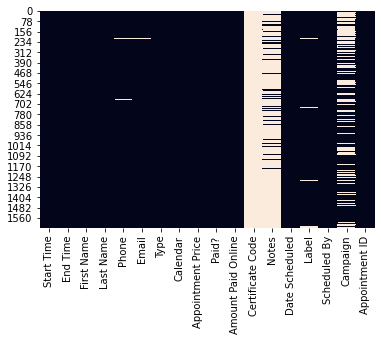

In [4]:
# Check for null values
sns.heatmap(intake.isnull(), cbar=False)

In [5]:
# Drop columns that won't be used
intake.drop(columns = ['Certificate Code', 'Label','Notes'], inplace = True)

In [6]:
intake.Campaign.value_counts()
# intake['Scheduled By'].value_counts()

checkoutsuccess                   434
hmapage                           186
ndpage                             94
cx                                 87
emaildrip                          81
hmafollowup                        74
trackingpage                       38
brightback                         31
socialdm                            8
dr_consult                          4
dr_hma                              4
lcm_210127-newyear-nonsubw-20       2
lcm_welcome_M_D21                   1
lcm_210127-newyear-nonsub-b-15      1
lcm_210127-newyear-nonsubw-15       1
Name: Campaign, dtype: int64

In [7]:
intake.loc[intake['Appointment ID'] == 507163280]

,Start Time,End Time,First Name,Last Name,Phone,Email,Type,Calendar,Appointment Price,Paid?,Amount Paid Online,Date Scheduled,Scheduled By,Campaign,Appointment ID
1118,2021-02-04 15:00:00,"February 4, 2021 3:20 pm",Nicole,Everitt,2542148028,nicole.everitt@yahoo.com,Hair Consultation,"Dr. Katelyn Cloyd, ND",0.0,no,0.0,2021-01-14,a client,checkoutsuccess,507163280


In [8]:
silver.loc[silver['APPOINTMENT_BODY_ID'] == 507163280]
# min(intake['Start Time'])

,EVENT_TS,EVENT_TS_UTC,ANONYMOUS_ID,EVENT,APPOINTMENT_BODY_CALENDAR,APPOINTMENT_BODY_FIRST_NAME,APPOINTMENT_BODY_DATETIME_CREATED,APPOINTMENT_BODY_CALENDAR_ID,APPOINTMENT_BODY_CALENDAR_TIMEZONE,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_BODY_TIMEZONE,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_LAST_NAME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_ID,APPOINTMENT_TYPE_ID,APPOINTMENT_BODY_CANCELED,APPOINTMENT_BODY_NO_SHOW
0,2021-01-13 21:57:52.309,2021-01-14 05:57:52.309,507163280,appointment_scheduled,"Dr. Katelyn Cloyd, ND",Nicole,2021-01-13 23:57:49.000,3508236.0,America/New_York,nicole.everitt@yahoo.com,"February 4, 2021",20.0,America/Chicago,2021-02-04 15:00:00.000,Everitt,Hair Consultation,507163280.0,12799707.0,False,NaN
4446,2021-01-13 21:57:50.525,2021-01-14 05:57:50.525,507163280,appointment_changed,"Dr. Katelyn Cloyd, ND",Nicole,2021-01-13 23:57:49.000,3508236.0,America/New_York,nicole.everitt@yahoo.com,"February 4, 2021",20.0,America/Chicago,2021-02-04 15:00:00.000,Everitt,Hair Consultation,507163280.0,12799707.0,False,NaN
4678,2021-02-04 12:13:56.146,2021-02-04 20:13:56.146,507163280,appointment_changed,"Dr. Katelyn Cloyd, ND",Nicole,2021-01-13 23:57:49.000,3508236.0,America/New_York,nicole.everitt@yahoo.com,"February 4, 2021",20.0,America/Chicago,2021-02-04 15:00:00.000,Everitt,Hair Consultation,507163280.0,12799707.0,False,NaN
4681,2021-02-04 12:14:01.390,2021-02-04 20:14:01.390,507163280,appointment_changed,"Dr. Katelyn Cloyd, ND",Nicole,2021-01-13 23:57:49.000,3508236.0,America/New_York,nicole.everitt@yahoo.com,"February 4, 2021",20.0,America/Chicago,2021-02-04 15:00:00.000,Everitt,Hair Consultation,507163280.0,12799707.0,False,NaN
4683,2021-02-04 11:52:51.653,2021-02-04 19:52:51.653,507163280,appointment_changed,"Dr. Katelyn Cloyd, ND",Nicole,2021-01-13 23:57:49.000,3508236.0,America/New_York,nicole.everitt@yahoo.com,"February 4, 2021",20.0,America/Chicago,2021-02-04 15:00:00.000,Everitt,Hair Consultation,507163280.0,12799707.0,False,NaN


In [9]:
# drop irrelevant appointments
na_dict= {'checkoutsuccess':np.nan,
          'ndpage':np.nan,
          'cx':np.nan,
          'emaildrip':np.nan,
          'trackingpage':np.nan,
          'socialdm':np.nan,
          'dr_consult':np.nan,
          'brightback':np.nan,
          'lcm_210127-newyear-nonsubw-20':np.nan,
          'lcm_welcome_M_D21':np.nan,
          'lcm_210127-newyear-nonsubw-15':np.nan
         }

intake['Campaign'].replace(na_dict, inplace = True)
intake.dropna(inplace = True)
intake['Campaign'].value_counts()

hmapage                           186
hmafollowup                        74
dr_hma                              4
lcm_210127-newyear-nonsub-b-15      1
Name: Campaign, dtype: int64

In [10]:
# Change dates to datetime Dtype
silver['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

silver['EVENT'].value_counts()

appointment_changed        19261
appointment_scheduled       5664
appointment_rescheduled      774
appointment_canceled         477
Name: EVENT, dtype: int64

In [11]:
clean = silver.groupby('EMAIL').agg({"APPOINTMENT_BODY_DATE":'min',\
                                'APPOINTMENT_BODY_TYPE':'last',\
                                'APPOINTMENT_BODY_CALENDAR':'last','APPOINTMENT_BODY_ID':'min'\
                               })
clean.shape

(4958, 4)

In [12]:
acuity = pd.merge(intake,clean, how='left',left_on='Appointment ID', right_on='APPOINTMENT_BODY_ID',copy=False)
acuity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Start Time                 265 non-null    datetime64[ns]
 1   End Time                   265 non-null    object        
 2   First Name                 265 non-null    object        
 3   Last Name                  265 non-null    object        
 4   Phone                      265 non-null    object        
 5   Email                      265 non-null    object        
 6   Type                       265 non-null    object        
 7   Calendar                   265 non-null    object        
 8   Appointment Price          265 non-null    float64       
 9   Paid?                      265 non-null    object        
 10  Amount Paid Online         265 non-null    float64       
 11  Date Scheduled             265 non-null    object        
 12  Schedule

In [13]:
acuity.Email.nunique()

265

## SUB

In [14]:
sub_2019=pd.merge(sub_20191,sub_20192,how='outer')
print('total',sub_2019.shape)
print('1',sub_20191.shape)
print('2',sub_20192.shape)

# Change dates to datetime 
sub_2019['FIRST_ORDER_AT'] = pd.to_datetime(sub_2019['FIRST_ORDER_AT'])
sub_2020['FIRST_ORDER_AT'] = pd.to_datetime(sub_2020['FIRST_ORDER_AT'])
sub_2021['FIRST_ORDER_AT'] = pd.to_datetime(sub_2021['FIRST_ORDER_AT'])

total (1147363, 7)
1 (506714, 7)
2 (640649, 7)


In [15]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

s19 = sub_2019.shape
email19 = sub_2019['EMAIL'].nunique()
print ('2019 = ',s19)
print ('2019 unique emails = ',email19)

s20 = sub_2020.shape
email20 = sub_2020['EMAIL'].nunique()
print ('2020 = ',s20)
print ('2020 unique emails = ',email20)

s21 = sub_2021.shape
email21 = sub_2021['EMAIL'].nunique()
print ('2021 = ',s21)
print ('2021 unique emails = ',email21)

2019 =  (1147363, 7)
2019 unique emails =  49744
2020 =  (727153, 7)
2020 unique emails =  82292
2021 =  (34172, 7)
2021 unique emails =  19819


In [16]:
# Aggregate
df18 = sub_2018.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df18.shape

(18970, 6)

In [17]:
# Aggregate
df19 = sub_2019.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df19.shape

(49744, 6)

In [18]:
# Aggregate
df20 = sub_2020.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df20.shape

(82292, 6)

In [19]:
# Aggregate
df21 = sub_2021.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df21.shape

(19819, 6)

In [20]:
sub1=pd.merge(sub_2019,sub_2018,how='outer')
sub2=pd.merge(sub_2020,sub_2021,how='outer')
sub3=pd.merge(sub1,sub2,how='outer')

ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [ ]:
sub3 = sub3.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
sub3.shape

## Merge

In [ ]:
sub = pd.merge(acuity,sub3, how='left',left_on='Email',right_on='EMAIL',copy=False)
sub.info()

In [ ]:
# clean up item sub
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan']= 'GrowthPlan 2'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2']= 'GrowthPlan'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan']= 'GrowthPlan 3'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2']= 'GrowthPlan 2'
sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub']= 'GrowthPlan 3'

sub['ITEM_SUB_TYPE'].value_counts()

In [ ]:
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Men']= 'Men'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan 2']= 'Balance'
sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='GrowthPlan 3']= 'Balance'

sub['ITEM_PRODUCT_CORE_CATEGORY'].value_counts()

In [ ]:
# Export data
sub.to_csv('intake_sub.csv')
sub.describe()